In [1]:
import os
from lib.methods import LoadCSV, PreProcessing, EchoStateNetwork
import warnings
warnings.simplefilter('ignore')

import matplotlib.pylab as plt
from matplotlib import gridspec
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.size"] = 30

In [2]:
os.chdir('../')

In [40]:
FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
DATA_NAME = 'MRI5_NVF1_10mm_0p2mmV'
ADDITIONAL_PATH = '_1'
SAMPLE_SPAN = [151000, 180000]
FILTER_METHOD = 'bandpass_filtering'
BANDPASS_PARAMS = {
                'passband_edge_freq':[90, 200], 
                'stopband_edge_freq':[20, 450], 
                'passband_edge_max_loss':1, 
                'stopband_edge_min_loss':10
                }
ESN_PARAMS = {
            'units':1300, 
            'SR':0.8, 
            'input_shape':10, 
            'output_shape':10, 
            'W_in_scale':0.1, 
            'W_res_density':0.1, 
            'leak_rate':1.0, 
            'alpha':0.01, 
            'seed':0
            }
TRAIN_TEST_DATA_PARAMS = {
                        'n_shift':10,
                        'n_dimension':10,
                        'n_train':5000,
                        'n_predstep':1
                        }

In [15]:
[t_data, mic_data] = LoadCSV(
                            file_path=FILE_DIR+DATA_NAME+ADDITIONAL_PATH+'.csv',
                            data_name_list=['t', 'mic'],
                            sample_span=[0, None]
                            )

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI5_NVF1_10mm_0p2mmV_1.csv
data list | t, mic


In [16]:
preprocess = PreProcessing(data=mic_data, t_data=t_data)
preprocess.filter(method=FILTER_METHOD, params=BANDPASS_PARAMS)
preprocess.cut(span=SAMPLE_SPAN, new_t=False)
preprocess.embed(n_shift=TRAIN_TEST_DATA_PARAMS['n_shift'], n_dimension=TRAIN_TEST_DATA_PARAMS['n_dimension'])
train_X, train_Y, test_X, test_Y = preprocess.train_test_split(
                                                            n_train=TRAIN_TEST_DATA_PARAMS['n_train'], 
                                                            n_predstep=TRAIN_TEST_DATA_PARAMS['n_predstep']
                                                            )
train_t = preprocess.t_data[TRAIN_TEST_DATA_PARAMS['n_predstep']:TRAIN_TEST_DATA_PARAMS['n_predstep']+train_Y.shape[0]]
test_t = preprocess.t_data[TRAIN_TEST_DATA_PARAMS['n_train']+TRAIN_TEST_DATA_PARAMS['n_predstep']:TRAIN_TEST_DATA_PARAMS['n_train']+TRAIN_TEST_DATA_PARAMS['n_predstep']+test_Y.shape[0]]

In [41]:
esn = EchoStateNetwork(
                    units=ESN_PARAMS['units'], 
                    SR=ESN_PARAMS['SR'], 
                    input_shape=ESN_PARAMS['input_shape'], 
                    output_shape=ESN_PARAMS['output_shape'], 
                    W_in_scale=ESN_PARAMS['W_in_scale'], 
                    W_res_density=ESN_PARAMS['W_res_density'], 
                    leak_rate=ESN_PARAMS['leak_rate'], 
                    alpha=ESN_PARAMS['alpha'], 
                    seed=ESN_PARAMS['seed']
                    )

In [42]:
esn.fit(in_layer_data=train_X, out_layer_data=train_Y)
pred_test_Y = esn.predict(test_X)

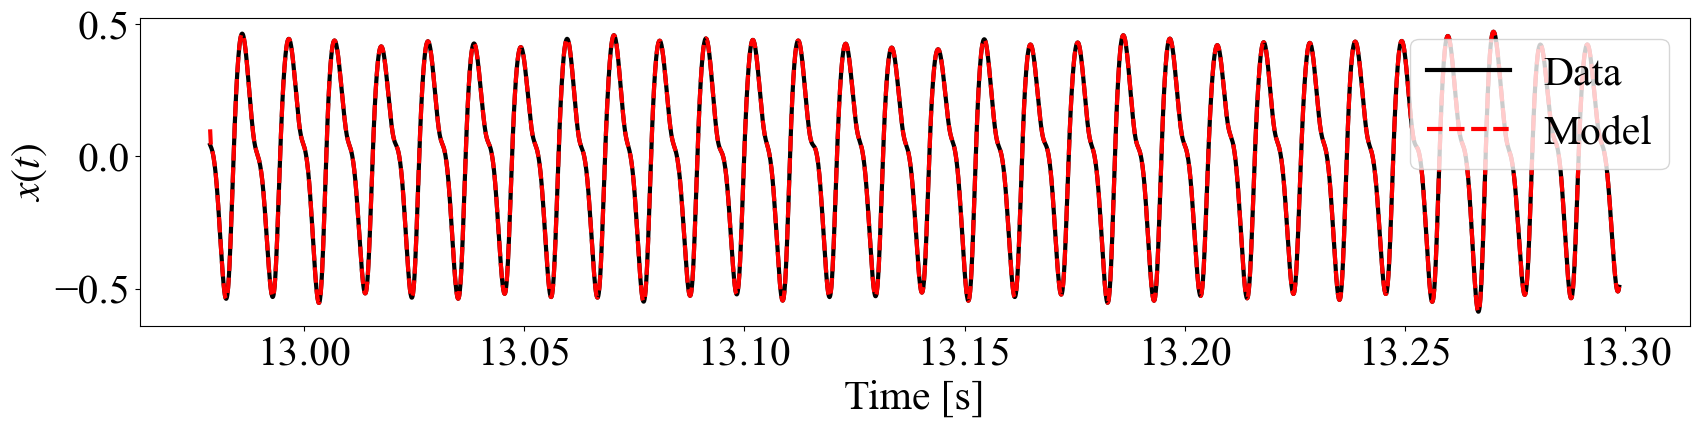

In [43]:
n_plot = 4000
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)
ax.plot(test_t[:n_plot], test_Y[:n_plot, 0, 0], c='k', label='Data', lw = 3)
ax.plot(test_t[:n_plot], pred_test_Y[:n_plot, 0], '--', c='r', label='Model', lw = 3)
ax.legend(loc='upper right')
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'$x(t)$')
plt.show()

In [44]:
n_freerun = 10000
freerun_test_Y = esn.freerun(in_layer_data0=test_X[0], pred_range=n_freerun, return_reservoir=False)

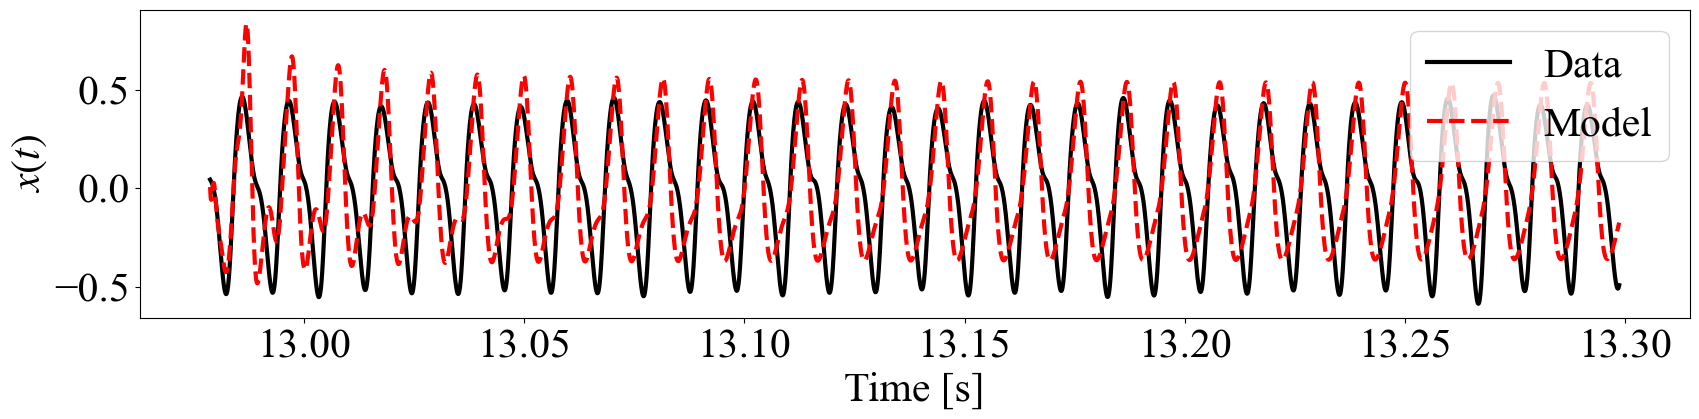

In [45]:
n_plot = 4000
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)
ax.plot(test_t[:n_plot], test_Y[:n_plot, 0, 0], c='k', label='Data', lw = 3)
ax.plot(test_t[:n_plot], freerun_test_Y[:n_plot, 0], '--', c='r', label='Model', lw = 3)
ax.legend(loc='upper right')
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'$x(t)$')
plt.show()

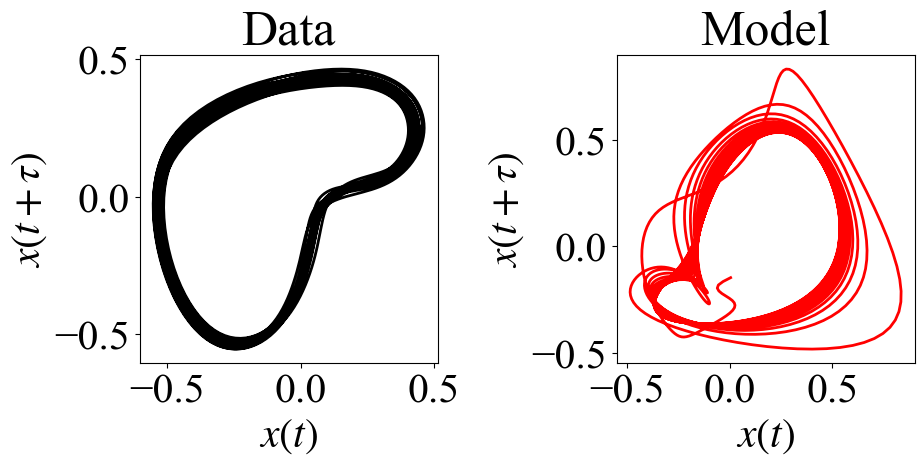

In [46]:
n_plot = 3000
n_shift = 20

spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 1],
                         wspace=0.6
                         )
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(spec[0])
ax1.set_title('Data', loc='center')
ax1.plot(test_Y[:n_plot, 0, 0], test_Y[n_shift:n_shift+n_plot, 0, 0], c='k', lw=2, label='Data')
ax1.set_xlabel(r'$x(t)$')
ax1.set_ylabel(r'$x(t+\tau)$')
ax.set_aspect('equal', 'datalim')
ax2 = fig.add_subplot(spec[1])
ax2.set_title('Model', loc='center')
ax2.plot(freerun_test_Y[:n_plot, 0], freerun_test_Y[n_shift:n_shift+n_plot, 0], c='r', lw=2, label='Model')
ax2.set_xlabel(r'$x(t)$')
ax2.set_ylabel(r'$x(t+\tau)$')
ax.set_aspect('equal', 'datalim')
plt.show()

In [11]:
lyapunov_exponents, dims = esn.computing_lyapunov_exponent(dt=T[1]-T[0])

In [7]:
import optuna
from scipy.stats import pearsonr
from lib.functions import rmse

In [11]:
def objective(trial):
    ESN_PARAMS = {
                'input_shape':10, 
                'output_shape':10, 
                'W_in_scale':0.1, 
                'W_res_density':0.1, 
                'leak_rate':1.0, 
                'seed':0
                }
    units = trial.suggest_int('units', 100, 1500)
    SR = trial.suggest_discrete_uniform('SR', 0.5, 1.5, 0.1)
    alpha = trial.suggest_discrete_uniform('alpha', 0.0001, 1.0, 0.0001)
    esn = EchoStateNetwork(
                        units=units, 
                        SR=SR, 
                        input_shape=ESN_PARAMS['input_shape'], 
                        output_shape=ESN_PARAMS['output_shape'], 
                        W_in_scale=ESN_PARAMS['W_in_scale'], 
                        W_res_density=ESN_PARAMS['W_res_density'], 
                        leak_rate=ESN_PARAMS['leak_rate'], 
                        alpha=alpha, 
                        seed=ESN_PARAMS['seed']
                        )
    esn.fit(in_layer_data=train_X, out_layer_data=train_Y)
    n_freerun = 10000
    freerun_test_Y = esn.freerun(in_layer_data0=test_X[0], pred_range=n_freerun, return_reservoir=False)
    corr, _ = pearsonr(freerun_test_Y[:n_freerun, 0], test_Y.reshape(test_Y.shape[0], test_Y.shape[2])[:n_freerun, 0])
    return 1.0 - corr

In [12]:
study = optuna.create_study()
study.optimize(objective, timeout=18000)

[I 2023-04-02 12:07:34,991] A new study created in memory with name: no-name-261c4774-9927-4fed-88ae-4a660382914d
[I 2023-04-02 12:07:47,052] Trial 0 finished with value: 0.0800647642932214 and parameters: {'units': 608, 'SR': 0.5, 'alpha': 0.4988}. Best is trial 0 with value: 0.0800647642932214.
[I 2023-04-02 12:07:49,656] Trial 1 finished with value: 0.16473334920316873 and parameters: {'units': 323, 'SR': 1.3, 'alpha': 0.3613}. Best is trial 0 with value: 0.0800647642932214.
[I 2023-04-02 12:07:58,142] Trial 2 finished with value: 0.47609929898788883 and parameters: {'units': 625, 'SR': 1.4, 'alpha': 0.8643000000000001}. Best is trial 0 with value: 0.0800647642932214.
[I 2023-04-02 12:08:03,736] Trial 3 finished with value: 0.07501342720028226 and parameters: {'units': 512, 'SR': 0.9, 'alpha': 0.2426}. Best is trial 3 with value: 0.07501342720028226.
[I 2023-04-02 12:08:32,148] Trial 4 finished with value: 0.07656757815659887 and parameters: {'units': 1156, 'SR': 0.7, 'alpha': 0.791

In [13]:
study.best_params

{'units': 1305, 'SR': 0.8, 'alpha': 0.309}